In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import sklearn as preprocessing
import glob

from google.colab import drive
drive.mount("/content/gdrive")

import os
import re
import pandas as pd
from google.colab import drive

# Define the custom sorting function
def custom_sort(filename):
    match = re.match(r'subj(\d+)_EMG_(\d+).csv', filename)
    if match:
        subj_number = int(match.group(1))
        file_number = int(match.group(2))
        return (subj_number, file_number)
    else:
        return (float('inf'),)  # Return a large number for filenames not matching the pattern

# List all files in the folder
path = r'/content/gdrive/MyDrive/EMG'
file_names = os.listdir(path)

# Filter only CSV files
csv_files = [file for file in file_names if file.endswith('.csv')]

# Sort files using the custom sorting function
sorted_csv_files = sorted(csv_files, key=custom_sort)

# Import CSV files into pandas DataFrame
dfs_EMG= []
for csv_file in sorted_csv_files:
    file_path = os.path.join(path, csv_file)
    df = pd.read_csv(file_path)
    if 'EMG' in csv_file:
     dfs_EMG.append(df)


import os
import re
import pandas as pd
from google.colab import drive

# Define the custom sorting function
def custom_sort(filename):
    match = re.match(r'subj(\d+)_IK_(\d+).csv', filename)
    if match:
        subj_number = int(match.group(1))
        file_number = int(match.group(2))
        return (subj_number, file_number)
    else:
        return (float('inf'),)  # Return a large number for filenames not matching the pattern

# List all files in the folder
path = r'/content/gdrive/MyDrive/IK/IK'
file_names = os.listdir(path)

# Filter only CSV files
csv_files = [file for file in file_names if file.endswith('.csv')]

# Sort files using the custom sorting function
sorted_csv_files = sorted(csv_files, key=custom_sort)

# Import CSV files into pandas DataFrame
dfs_IK= []
for csv_file in sorted_csv_files:
    file_path = os.path.join(path, csv_file)
    df = pd.read_csv(file_path)
    if 'IK' in csv_file:
     dfs_IK.append(df)

butter_highpass_order=2
butter_lowpass_order=2
highpass_f=25
lowpass_f=6
source_rate=1000
final_rate=100
# middle_rate=2000###2048 t0 2000
remove_to_samples=0###masalan 20 bashe 10 as ye taraf 10 ham as tarafe dige
w1=2000###window length
OL=1960###overlap
data_namm=157###chanta data bere to halghe bara train
pred_num=1##predict nemune t+chankd beshe pred
start_out1=200##### knee as chan shoru she baste be pankere emg masalan 2000 emg to 2000 hz moadele 100 tast as 100

overlap_knee=196####baste be panjere knee chegadr overlap mikhaim
knee_move=start_out1-overlap_knee
val_separate_percent=0.9



###network####albate chon sakhtar avas momkene beshe motefavete
n_timesteps=200
n_features=4
n_features_single=1
out_features=1
numberOfUnits=64

Drop_out_rate=0.5#maghale gofte



batch_size1=2000

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, resample
import matplotlib.pyplot as plt

# Define a high-pass Butterworth filter
def butter_highpass(cutoff, fs, order=butter_highpass_order):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

# Define a low-pass Butterworth filter
def butter_lowpass(cutoff, fs, order=butter_lowpass_order):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Function to get the EMG envelope
def get_emg_envelope(emg_data, fs_emg):
    # Remove columns with NaN data
    emg_data = emg_data[:, ~np.isnan(emg_data[0, :])]

    # High-pass filter to remove wire artifacts
    b, a = butter_highpass(highpass_f, fs_emg, order=butter_highpass_order)
    emg_filtered = filtfilt(b, a, emg_data, axis=0)

    # Rectify the EMG signals
    emg_rectified = np.abs(emg_filtered)

    # Low-pass filter to get the envelope
    b, a = butter_lowpass(lowpass_f, fs_emg, order=butter_lowpass_order)
    emg_envelope = filtfilt(b, a, emg_rectified, axis=0)

    # Subtract the minimum value from the envelope
    emg_envelope_subs = emg_envelope - np.min(emg_envelope, axis=0)

    return emg_envelope_subs


def resample_emg_signal(emg_envelope, original_rate, target_rate, remove_samples=remove_to_samples):
    if emg_envelope.size == 0:
        return np.empty_like(emg_envelope)

    num_samples = int(len(emg_envelope) * target_rate / original_rate)
    resampled_emg = resample(emg_envelope, num_samples, axis=0)

    if remove_samples > 0 and len(resampled_emg) > 2 * remove_samples:
        resampled_emg = resampled_emg[remove_samples:-remove_samples]

    return resampled_emg
# Function to process the EMG data
def process_emg_data(emg_data, original_rate=source_rate, target_rate=final_rate):
    # Get the EMG envelope
    emg_envelope = get_emg_envelope(emg_data, original_rate)

    # Resample the EMG envelope to the target rate
    resampled_emg = resample_emg_signal(emg_envelope, original_rate, target_rate, remove_samples=remove_to_samples)

    # Normalize the signal
    normalized_emg = (resampled_emg - np.mean(resampled_emg)) / np.std(resampled_emg)

    return normalized_emg

# Function to handle online processing with windowing
def online_emg_processing(df, window_length=w1, overlap=OL, original_rate=source_rate, target_rate=final_rate):
    step_size = window_length - overlap
    windows = []

    emg_data = df
    # emg_data=resample_emg_signal(emg_data, source_rate,middle_rate, remove_samples=remove_to_samples)
    for start in range(0, len(emg_data) - window_length + 1, step_size):
        window = emg_data[start:start + window_length, :]
        # original_rate1=middle_rate
        # Process the window
        processed_window = process_emg_data(window, original_rate, target_rate)
        windows.append(processed_window)

    return windows


In [4]:

dfs_EMG1 = []

# Process each dataframe in dfs_EMG
for emg in dfs_EMG:
    # Get the total number of rows
    total_rows = len(emg)
    split_size = total_rows // 4  # Calculate size for each split

    # Split EMG data into 4 parts and append to dfs_EMG1
    for i in range(4):
        start_idx = i * split_size
        if i < 3:
            end_idx = start_idx + split_size
        else:
            end_idx = total_rows  # Ensure the last split captures remaining rows

        dfs_EMG1.append(emg.iloc[start_idx:end_idx].copy())
# Verify the results
print(f"Original dfs_EMG length: {len(dfs_EMG)}")
print(f"New dfs_EMG1 length: {len(dfs_EMG1)}")  # Should be 4x the original length

# # Verify the results
# print(f"Original dfs_EMG length: {len(dfs_EMG)}")
# print(f"New dfs_EMG1 length: {len(dfs_EMG1)}")  # Should be 4x the original length

# # Check shapes
# for i in range(len(dfs_EMG1)):
#     print(f"dfs_EMG1[{i}]: {dfs_EMG1[i].shape}")

Original dfs_EMG length: 157
New dfs_EMG1 length: 628


In [5]:
dfs_IK1 = []

# Process each dataframe in dfs_IK
for ik in dfs_IK:
    # Get the total number of rows
    total_rows = len(ik)
    split_size = total_rows // 4  # Calculate size for each split

    # Split IK data into 4 parts and append to dfs_IK1
    for i in range(4):
        start_idx = i * split_size
        if i < 3:
            end_idx = start_idx + split_size
        else:
            end_idx = total_rows  # Ensure the last split captures remaining rows

        dfs_IK1.append(ik.iloc[start_idx:end_idx].copy())

# # Verify the results
# print(f"Original dfs_IK length: {len(dfs_IK)}")
# print(f"New dfs_IK1 length: {len(dfs_IK1)}")  # Should be 4x the original length

# # Check shapes
# for i in range(len(dfs_IK1)):
#     print(f"dfs_IK1[{i}]: {dfs_IK1[i].shape}")
print(f"Original dfs_IK length: {len(dfs_IK)}")
print(f"New dfs_IK1 length: {len(dfs_IK1)}")  # Should be 4x the original length

Original dfs_IK length: 157
New dfs_IK1 length: 628


In [6]:
# data_namm=(len(dfs_EMG1))
data_namm=(2)
# Example usage with your existing data
df_all1 = []

# for i in range(len(dfs_EMG1)):
for i in range(data_namm):
  # if i!=17:
    df = np.array(dfs_EMG1[i])
    # Process the dataframe using online windowing and processing
    processed_windows = online_emg_processing(df, window_length=w1, overlap=OL, original_rate=source_rate, target_rate=final_rate)
    # processed_windows1 =resample_emg_signal(processed_windows, 2000, 100, remove_samples=0)

    df_all1.append(processed_windows)


<ipython-input-32-7f70a5b4e7f2>:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


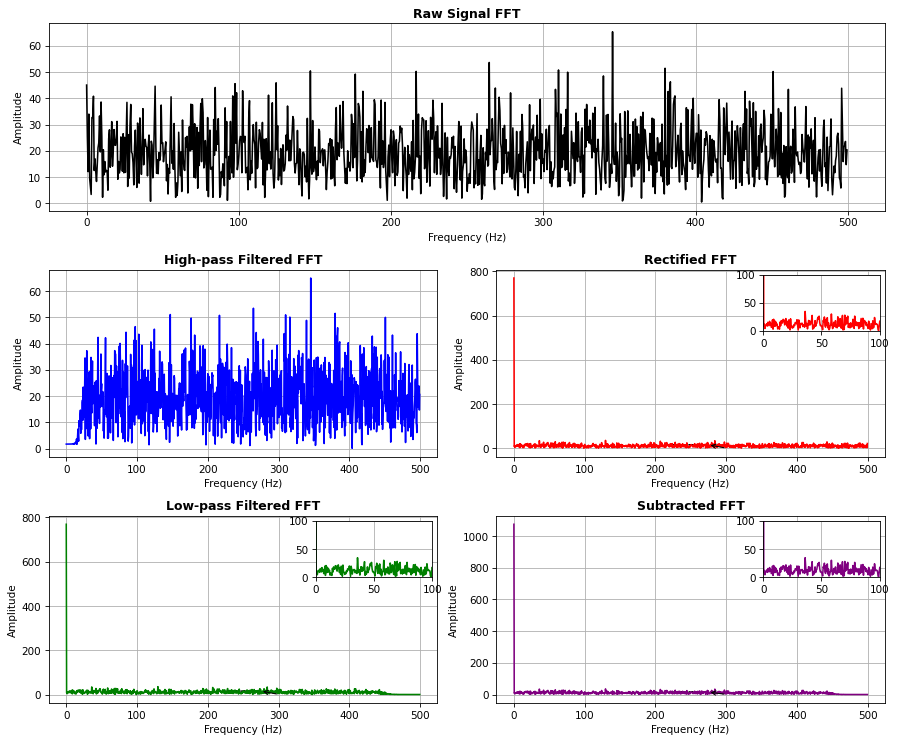

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Define filter parameters
highpass_f = 20  # High-pass cutoff frequency
lowpass_f = 450  # Low-pass cutoff frequency
fs_emg = 1000  # Sampling frequency
butter_highpass_order = 4
butter_lowpass_order = 4

# Generate sample EMG data (simulated)
np.random.seed(42)
emg_data = np.random.randn(2000) * 0.5

# Step 1: Raw Signal
fft_raw = np.fft.fft(emg_data)
freq_raw = np.fft.fftfreq(len(emg_data), d=1/fs_emg)

# Step 3: High-pass filter to remove wire artifacts
b, a = butter(butter_highpass_order, highpass_f / (fs_emg / 2), btype='high')
emg_filtered = filtfilt(b, a, emg_data)

fft_highpass = np.fft.fft(emg_filtered)
freq_highpass = np.fft.fftfreq(len(emg_filtered), d=1/fs_emg)

# Step 4: Rectify the EMG signals
emg_rectified = np.abs(emg_filtered)

fft_rectified = np.fft.fft(emg_rectified)
freq_rectified = np.fft.fftfreq(len(emg_rectified), d=1/fs_emg)

# Step 5: Low-pass filter to get the envelope
b, a = butter(butter_lowpass_order, lowpass_f / (fs_emg / 2), btype='low')
emg_envelope = filtfilt(b, a, emg_rectified)

fft_lowpass = np.fft.fft(emg_envelope)
freq_lowpass = np.fft.fftfreq(len(emg_envelope), d=1/fs_emg)

# Step 6: Subtract minimum value
emg_envelope_subs = emg_envelope - np.min(emg_envelope)

fft_subtracted = np.fft.fft(emg_envelope_subs)
freq_subtracted = np.fft.fftfreq(len(emg_envelope_subs), d=1/fs_emg)

# Plot all FFTs with new layout
plt.figure(figsize=(12, 10), dpi=75)

# Raw signal at the top (full width)
plt.subplot(3, 2, (1, 2))  # Spans columns 1 and 2
plt.plot(freq_raw[:len(freq_raw)//2], np.abs(fft_raw)[:len(freq_raw)//2], label="Raw Signal", color='black', linewidth=1.5)
plt.title("Raw Signal FFT", fontsize=12, fontweight="bold")
plt.xlabel("Frequency (Hz)", fontsize=10)
plt.ylabel("Amplitude", fontsize=10)
plt.grid(True)

# High-pass filter (top-left)
plt.subplot(3, 2, 3)
plt.plot(freq_highpass[:len(freq_highpass)//2], np.abs(fft_highpass)[:len(freq_highpass)//2], label="High-pass Filtered", color='blue', linewidth=1.5)
plt.title("High-pass Filtered FFT", fontsize=12, fontweight="bold")
plt.xlabel("Frequency (Hz)", fontsize=10)
plt.ylabel("Amplitude", fontsize=10)
plt.grid(True)

# Rectified signal (top-right) with circle and inset
ax1 = plt.subplot(3, 2, 4)
plt.plot(freq_rectified[:len(freq_rectified)//2], np.abs(fft_rectified)[:len(freq_rectified)//2], label="Rectified", color='red', linewidth=1.5)
plt.title("Rectified FFT", fontsize=12, fontweight="bold")
plt.xlabel("Frequency (Hz)", fontsize=10)
plt.ylabel("Amplitude", fontsize=10)
plt.grid(True)
# Add circle at center (250 Hz)
ellipse = Ellipse((250, np.abs(fft_rectified[:len(freq_rectified)//2])[250]), width=50, height=0.5, fill=False, color='black', linestyle='dashed')
ax1.add_patch(ellipse)
# Add inset for 0-50 Hz
axins1 = inset_axes(ax1, width="30%", height="30%", loc='upper right')
axins1.plot(freq_rectified[:len(freq_rectified)//2], np.abs(fft_rectified)[:len(freq_rectified)//2], color='red', linewidth=1.5)
axins1.set_xlim(0, 100)
axins1.set_ylim(0, 100)
axins1.grid(True)
# Add arrow from circle edge
ax1.annotate('', xy=(275, np.abs(fft_rectified[:len(freq_rectified)//2])[250]), xytext=(300, 1.0),
             arrowprops=dict(arrowstyle="->", color='black'))

# Low-pass filter (middle-left) with circle and inset
ax2 = plt.subplot(3, 2, 5)
plt.plot(freq_lowpass[:len(freq_lowpass)//2], np.abs(fft_lowpass)[:len(freq_lowpass)//2], label="Low-pass Filtered", color='green', linewidth=1.5)
plt.title("Low-pass Filtered FFT", fontsize=12, fontweight="bold")
plt.xlabel("Frequency (Hz)", fontsize=10)
plt.ylabel("Amplitude", fontsize=10)
plt.grid(True)
# Add circle at center (250 Hz)
ellipse = Ellipse((250, np.abs(fft_lowpass[:len(freq_lowpass)//2])[250]), width=50, height=0.5, fill=False, color='black', linestyle='dashed')
ax2.add_patch(ellipse)
# Add inset for 0-50 Hz
axins2 = inset_axes(ax2, width="30%", height="30%", loc='upper right')
axins2.plot(freq_lowpass[:len(freq_lowpass)//2], np.abs(fft_lowpass)[:len(freq_lowpass)//2], color='green', linewidth=1.5)
axins2.set_xlim(0, 100)
axins2.set_ylim(0, 100)
axins2.grid(True)
# Add arrow from circle edge
ax2.annotate('', xy=(275, np.abs(fft_lowpass[:len(freq_lowpass)//2])[250]), xytext=(300, 1.0),
             arrowprops=dict(arrowstyle="->", color='black'))

# Subtracted signal (middle-right) with circle and inset
ax3 = plt.subplot(3, 2, 6)
plt.plot(freq_subtracted[:len(freq_subtracted)//2], np.abs(fft_subtracted)[:len(freq_subtracted)//2], label="Subtracted", color='purple', linewidth=1.5)
plt.title("Subtracted FFT", fontsize=12, fontweight="bold")
plt.xlabel("Frequency (Hz)", fontsize=10)
plt.ylabel("Amplitude", fontsize=10)
plt.grid(True)
# Add circle at center (250 Hz)
ellipse = Ellipse((250, np.abs(fft_subtracted[:len(freq_subtracted)//2])[250]), width=50, height=0.5, fill=False, color='black', linestyle='dashed')
ax3.add_patch(ellipse)
# Add inset for 0-50 Hz
axins3 = inset_axes(ax3, width="30%", height="30%", loc='upper right')
axins3.plot(freq_subtracted[:len(freq_subtracted)//2], np.abs(fft_subtracted)[:len(freq_subtracted)//2], color='purple', linewidth=1.5)
axins3.set_xlim(0, 100)
axins3.set_ylim(0, 100)
axins3.grid(True)
# Add arrow from circle edge
ax3.annotate('', xy=(275, np.abs(fft_subtracted[:len(freq_subtracted)//2])[250]), xytext=(300, 1.0),
             arrowprops=dict(arrowstyle="->", color='black'))

plt.tight_layout()
plt.show()